In [1]:
import numpy as np
import torch
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.optim as optim
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append(os.path.dirname(sys.path[0]))

In [3]:
from model.encoder_perceiver import EncoderPerceiver
from model.encoder_cnn import EncoderResNet
from model.decoder import CaptioningTransformer
from utils.flickr8k_util import FlickrDataset, CapsCollate
from model.utils import show_image
from experiment.solver import CaptioningSolver

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# load data
transform = T.Compose([
                T.Resize((224, 224)),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # for flickr8k
            ])

In [6]:
base_dir = os.getcwd()[:-len("/notebook")]
data_location = base_dir + "/data/Flickr8k"

In [7]:
dataset =  FlickrDataset(
    root_dir = data_location + "/Images",
    caption_file = data_location + "/captions.txt",
    transform = transform,
    verbose = True )

building vocab
buidling caption alias


In [8]:
caption_per_image = 5
num_data = len(dataset)
num_figures = num_data/caption_per_image
test_split = 0.2
val_split = 0.2
train_idx = int((1 - test_split - val_split) * num_figures)
train_abs_idx = train_idx * caption_per_image
val_idx = train_idx + int(val_split * num_figures)
val_abs_idx = val_idx * caption_per_image

In [9]:
train_indices = range(train_abs_idx)
val_indices = range(train_abs_idx, val_abs_idx)
test_indices = range(val_abs_idx, num_data)

In [10]:
# writing the dataloader
# setting the constants
BATCH_SIZE = 32
NUM_WORKER = 2

# token to represent the padding
pad_idx = dataset.vocab.stoi["<NULL>"]

loader_train = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    sampler = sampler.SubsetRandomSampler(train_indices),
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

loader_val = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    sampler = sampler.SubsetRandomSampler(val_indices),
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

loader_test = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    sampler = sampler.SubsetRandomSampler(test_indices),
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

In [11]:
# create models
input_dim = 224 * 224
input_channels = 3
feature_dim = 512
word_emb_dim = 256
encoder = EncoderPerceiver(input_dim, input_channels = input_channels, 
                             num_iterations = 2, num_transformer_blocks = 4,
                             num_latents=32, latent_dim = feature_dim, 
                             cross_heads=4, cross_dim_head=16, 
                             latent_heads=4, latent_dim_head=16,
                             attn_dropout=0.5, ff_dropout=0.5)
decoder = CaptioningTransformer(dataset.vocab.stoi, input_dim=feature_dim, 
                                  wordvec_dim = word_emb_dim, max_length=50)

In [12]:
encoder_optimizer = optim.Adam(encoder.parameters(), 1e-3)
decoder_optimizer = optim.Adam(decoder.parameters(), 2e-3)

In [13]:
solver = CaptioningSolver(encoder, decoder, 
                          encoder_optimizer, decoder_optimizer,
                          dataset.vocab.itos, dataset.caption_alias, 
                          device = device, print_every = 100)

In [14]:
solver.train(loader_train, loader_val, num_epochs=2)

begin training epoch 1 of 2 epochs
training batch 0 of 1517 batches
training batch 100 of 1517 batches
training batch 200 of 1517 batches
training batch 300 of 1517 batches
training batch 400 of 1517 batches
training batch 500 of 1517 batches
training batch 600 of 1517 batches
training batch 700 of 1517 batches
training batch 800 of 1517 batches
training batch 900 of 1517 batches
training batch 1000 of 1517 batches
training batch 1100 of 1517 batches
training batch 1200 of 1517 batches
training batch 1300 of 1517 batches
training batch 1400 of 1517 batches
training batch 1500 of 1517 batches
finish training epoch 1 of 2 epochs
begin validation epoch 1 of 2 epochs
computing BLEU score on validation
finish validation epoch 1 of 2 epochs
begin training epoch 2 of 2 epochs
training batch 83 of 1517 batches
training batch 183 of 1517 batches
training batch 283 of 1517 batches
training batch 383 of 1517 batches
training batch 483 of 1517 batches
training batch 583 of 1517 batches
training ba

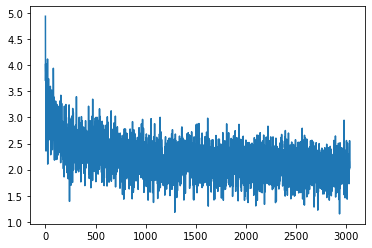

In [19]:
# visualize training
model_name = "baseline"
plt.plot(solver.train_loss_history)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.grid()
plt.title("Loss history during training on train set")
plt.savefig(base_dir + "/results/{}_train_loss.png".format(model_name), dpi=300, bbox_inches="tight")
plt.show()

plt.plot(solver.val_loss_history)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.grid()
plt.title("Loss history during training on validation set")
plt.savefig(base_dir + "/results/{}_val_loss.png".format(model_name), dpi=300, bbox_inches="tight")
plt.show()

plt.plot(solver.train_bleu)
plt.xlabel("epoch")
plt.ylabel("BLEU-4 score")
plt.grid()
plt.title("BLEU-4 score during training on training set")
plt.savefig(base_dir + "/results/{}_train_BLEU.png".format(model_name), dpi=300, bbox_inches="tight")
plt.show()

plt.plot(solver.val_bleu)
plt.xlabel("epoch")
plt.ylabel("BLEU-4 score")
plt.grid()
plt.title("BLEU-4 score during training on training set")
plt.savefig(base_dir + "/results/{}_val_BLEU.png".format(model_name), dpi=300, bbox_inches="tight")
plt.show()

print("maximum BLEU-4 score on validation: ", np.max(solver.val_bleu))

In [ ]:
# inference

def inference(split_name, loader, filename=None):

    imgs, captions = next(iter(loader_train))
    img = imgs[0] # pick first image from the batch
    caption_vec = captions[0]
    ground_truth = decode_captions(caption_vec.detach().cpu().numpy(), dataset.vocab.itos)
    ground_truth = strip_start_end(ground_truth)
    feature = encoder(img.to(device=device, dtype=torch.float32).reshape(1, 3, 224, 224))
    caption_vec_pred = decoder.sample(feature, max_length=50, device=device)
    predict = decode_captions(caption_vec_pred, dataset.vocab.itos)[0]
    predict = strip_start_end(predict)

    title = "Split:{}\nGT:{}\nPredict:{}".format(split_name, ground_truth, predict)

    inp = img.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    plt.axis("off")
    plt.title(title)
    plt.savefig(base_dir+"/results/"+filename)
    plt.show()

In [ ]:
# sample 5 images from train and val
for idx in range(5):
    split_name = "train"
    inference(split_name, loader_train, "inf_{}_{}.png".format(split_name, idx))
    
for idx in range(5):
    split_name = "val"
    inference(split_name, loader_val, "inf_{}_{}.png".format(split_name, idx))

In [ ]:
# run on test, only run once!
solver._val_step(loader_test)
bleu_test = solver.val_bleu[-1]
print("BLEU-4 Score on test set: ", bleu_test)